In [5]:

import os
import random
import time

import dill as pickle
import numpy as np
import torch
from torch.distributions import Categorical
from tqdm import tqdm

from environment import GridWorld
from subrl.utils.network import append_state
from subrl.utils.network import policy as agent_net
from visualization import Visu
from subpo import calculate_submodular_reward, compute_subpo_advantages

workspace = "NM"

/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:

workspace = "subrl"

params = {
    "env": {
        "start": 1,
        "step_size": 0.1,
        "shape": {"x": 30, "y": 30},
        "horizon": 80,
        "node_weight": "constant",
        "disc_size": "small",
        "n_players": 3,
        "Cx_lengthscale": 2,
        "Cx_noise": 0.001,
        "Fx_lengthscale": 1,
        "Fx_noise": 0.001,
        "Cx_beta": 1.5,
        "Fx_beta": 1.5,
        "generate": False,
        "env_file_name": 'env_data.pkl',
        "cov_module": 'Matern',
        "stochasticity": 0.0,
        "domains": "single_room",
        "num": 1,
    },
    "alg": {
        "gamma": 1,
        "type": "NM",
        "ent_coef": 0.0,
        "epochs": 50,
        "lr": 0.01
    },
    "common": {
        "a": 1,
        "subgrad": "greedy",
        "grad": "pytorch",
        "algo": "both",
        "init": "deterministic",
        "batch_size": 500
    },
    "visu": {
        "wb": "online",
        "a": 1
    }
}

env_load_path = workspace + \
    "/environments/" + params["env"]["node_weight"]+ "/env_1" 

params['env']['num'] = 1
# start a new wandb run to track this script
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="code-" + params["env"]["node_weight"],
#     mode=params["visu"]["wb"],
#     config=params
# )

epochs = params["alg"]["epochs"]

H = params["env"]["horizon"]
MAX_Ret = 2*(H+1)
if params["env"]["disc_size"] == "large":
    MAX_Ret = 3*(H+2)
    
env = GridWorld(
    env_params=params["env"], common_params=params["common"], visu_params=params["visu"], env_file_path=env_load_path)
node_size = params["env"]["shape"]['x']*params["env"]["shape"]['y']
# TransitionMatrix = torch.zeros(node_size, node_size)

if params["env"]["node_weight"] == "entropy" or params["env"]["node_weight"] == "steiner_covering" or params["env"]["node_weight"] == "GP": 
    a_file = open(env_load_path +".pkl", "rb")
    data = pickle.load(a_file)
    a_file.close()

if params["env"]["node_weight"] == "entropy":
    env.cov = data
if params["env"]["node_weight"] == "steiner_covering":
    env.items_loc = data
if params["env"]["node_weight"] == "GP":
    env.weight = data

visu = Visu(env_params=params["env"])
# plt, fig = visu.stiener_grid( items_loc=env.items_loc, init=34)
# wandb.log({"chart": wandb.Image(fig)})
# plt.close()
# Hori_TransitionMatrix = torch.zeros(node_size*H, node_size*H)
# for node in env.horizon_transition_graph.nodes:
#     connected_edges = env.horizon_transition_graph.edges(node)
#     for u, v in connected_edges:
#         Hori_TransitionMatrix[u[0]*node_size+u[1], v[0]*node_size + v[1]] = 1.0
env.get_horizon_transition_matrix()
# policy = Policy(TransitionMatrix=TransitionMatrix, Hori_TransitionMatrix=Hori_TransitionMatrix, ActionTransitionMatrix=env.Hori_ActionTransitionMatrix[:, :, :, 0],
#                 agent_param=params["agent"], env_param=params["env"])


x_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001, 7.4999, 7.5001, 8.4999, 8.5001, 9.4999, 9.5001, 10.4999, 10.5001, 11.4999, 11.5001, 12.4999, 12.5001, 13.4999, 13.5001, 14.4999, 14.5001, 15.4999, 15.5001, 16.4999, 16.5001, 17.4999, 17.5001, 18.4999, 18.5001, 19.4999, 19.5001, 20.4999, 20.5001, 21.4999, 21.5001, 22.4999, 22.5001, 23.4999, 23.5001, 24.4999, 24.5001, 25.4999, 25.5001, 26.4999, 26.5001, 27.4999, 27.5001, 28.4999, 28.5001, 29.4999, 29.5001]
y_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001, 7.4999, 7.5001, 8.4999, 8.5001, 9.4999, 9.5001, 10.4999, 10.5001, 11.4999, 11.5001, 12.4999, 12.5001, 13.4999, 13.5001, 14.4999, 14.5001, 15.4999, 15.5001, 16.4999, 16.5001, 17.4999, 17.5001, 18.4999, 18.5001, 19.4999, 19.5001, 20.4999, 20.5001, 21.4999, 21.5001, 22.4999, 22.5001, 23.4999, 23.5001, 24.4999, 24.50

In [7]:
def select_cell_from_archive(archive):
    """
    Select a cell from the archive for exploration.
    Cells with the fewest selection counts are prioritized.
    """
    if not archive:
        return None, None

    # Find the minimum selection count
    min_times_selected = float('inf')
    for cell_id in archive:
        if archive[cell_id]['times_selected'] < min_times_selected:
            min_times_selected = archive[cell_id]['times_selected']
    
    # Find all cells with the minimum selection count
    least_visited_cells = []
    for cell_id in archive:
        if archive[cell_id]['times_selected'] == min_times_selected:
            least_visited_cells.append(cell_id)
            
    #  Randomly select one of these cells
    selected_cell_id = random.choice(least_visited_cells)
    
    return selected_cell_id, archive[selected_cell_id]

def sample_excellent_trajectories(filepath="one_Room_go_explore_archive_spacetime.pkl", 
                                  method='top_n', 
                                  n=10, 
                                  p=0.1, 
                                  threshold=0):
    """
        Load data from the Go-Explore archive and sample high-quality trajectories based on the specified method.

        Args:
            filepath (str): Path to the .pkl archive file.
            method (str): Sampling method. Options are 'top_n', 'top_p', or 'threshold'.
            n (int): Number of trajectories to sample for the 'top_n' method.
            p (float): Percentage of top trajectories to sample for the 'top_p' method (e.g., 0.1 means top 10%).
            threshold (float): Minimum reward threshold for the 'threshold' method.
        
        Returns:
            list: A list of trajectory dictionaries with high rewards, sorted in descending order of reward.
                  Returns an empty list if the file does not exist or the archive is empty.
    """
    # 1. Check if the file exists and load the data
    if not os.path.exists(filepath):
        print(f"Error: Archive file not found '{filepath}'")
        return []
    
    try:
        with open(filepath, "rb") as f:
            archive = pickle.load(f)
        if not archive:
            print("警告：存檔庫為空。")
            return []
    except Exception as e:
        print(f"讀取文件時出錯: {e}")
        return []

    # 2. 提取所有軌跡數據並按獎勵排序
    # archive.values() 返回的是包含 reward, states, actions 等信息的字典
    all_trajectories_data = list(archive.values())
    
    # 按 'reward' 鍵從高到低排序
    all_trajectories_data.sort(key=lambda x: x['reward'], reverse=True)

    # 3. 根據指定方法進行採樣
    sampled_trajectories = []
    if method == 'top_n':
        # 取獎勵最高的前 N 條
        num_to_sample = min(n, len(all_trajectories_data))
        sampled_trajectories = all_trajectories_data[:num_to_sample]
        print(f"方法: Top-N。從 {len(all_trajectories_data)} 條軌跡中篩選出最好的 {len(sampled_trajectories)} 條。")

    elif method == 'top_p':
        # 取獎勵最高的前 P%
        if not (0 < p <= 1):
            print("錯誤：百分比 'p' 必須在 (0, 1] 之間。")
            return []
        num_to_sample = int(len(all_trajectories_data) * p)
        sampled_trajectories = all_trajectories_data[:num_to_sample]
        print(f"方法: Top-P。從 {len(all_trajectories_data)} 條軌跡中篩選出最好的前 {p*100:.1f}% ({len(sampled_trajectories)} 條)。")

    elif method == 'threshold':
        # 取獎勵高於指定門檻的所有軌跡
        sampled_trajectories = [data for data in all_trajectories_data if data['reward'] >= threshold]
        print(f"方法: Threshold。從 {len(all_trajectories_data)} 條軌跡中篩選出 {len(sampled_trajectories)} 條獎勵不低於 {threshold} 的軌跡。")
        
    else:
        print(f"錯誤：未知的採樣方法 '{method}'。請使用 'top_n', 'top_p', 或 'threshold'。")

    return sampled_trajectories

In [8]:
def expand_trajectory_states(trajectory_states, H):
    """
    将轨迹状态按照 append_state 的方式进行拓展
    
    Args:
        trajectory_states: 轨迹中的状态列表
        H: 时间范围参数
        
    Returns:
        expanded_states: 拓展后的状态列表
    """
    expanded_states = []
    
    # 模拟原始代码中的 mat_state 构建过程
    mat_state = []
    
    for i, state in enumerate(trajectory_states):
        mat_state.append(state)
        
        # 对于除了最后一个状态外的所有状态，都进行 append_state 拓展
        if i < H - 1:
            # 使用 append_state 函数进行状态拓展
            batch_state = append_state(mat_state, H-1)
            expanded_states.append(batch_state)
        else:
            expanded_states.append(expanded_states[-1])  # 最后一个状态不需要拓展，直接重复最后一个状态
    
    return expanded_states

# 使用示例：拓展最佳轨迹的状态
H = params["env"]["horizon"]  # 使用环境参数中的 horizon


In [9]:

#基于embedding的模仿学习
import torch
import torch.nn.functional as F  # 这里导入 F
import torch.nn as nn

class TemporalStateEncoder(nn.Module):
    def __init__(self, num_states=98, embed_dim=16, hidden_dim=32):
        super().__init__()
        self.embedding = nn.Embedding(num_states, embed_dim)
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim)

    def forward(self, state_seq):
        indices = [i for i in state_seq if i >= 0]
        if not indices:
            return torch.zeros(self.lstm.hidden_size)

        input_emb = self.embedding(torch.tensor(indices).long()).unsqueeze(1)  # [T, 1, D]
        _, (h_n, _) = self.lstm(input_emb)
        return h_n.squeeze(0).squeeze(0)  # [hidden_dim]

def encode_temporal_state(state_seq, embed_table):
    """
    输入: state_seq: Tensor[H]，如 [34, 33, -1, ..., -1]
    输出: Tensor[embed_dim]，嵌入向量
    """
    indices = [i for i in state_seq if i >= 0]  # 去除 -1
    if not indices:
        return torch.zeros(embed_table.embedding_dim)
    indices_tensor = torch.tensor(indices, dtype=torch.long)
    embeds = embed_table(indices_tensor)
    return embeds.mean(dim=0)
def encode_temporal_state2(state_seq, encoder):
    return encoder(state_seq)

def submodular_selector_temporal(trajectories, embed_table,temporal_encoder, budget=50, lambda_div=0.5, per_traj_limit=True,horizon=40):
    """
    改进版子模选择器：
    - 使用欧几里得距离作为 diversity 惩罚项
    - 可选启用：每条轨迹最多选一个状态（保证轨迹多样性）
    """
    state_vectors = []
    action_labels = []
    traj_ids = []

    for traj_id, traj in enumerate(trajectories):
        states = [int(s.item()) for s in traj['states']]
        actions = traj['actions']
        for t, action in enumerate(actions):
            temporal_state = [-1]*horizon
            for h in range(t+1):
                temporal_state[h] = states[h]
            temporal_tensor = torch.tensor(temporal_state, dtype=torch.long)
            # encoded = encode_temporal_state(temporal_tensor, embed_table) # 使用嵌入表编码
            # temporal_encoder = TemporalStateEncoder() #使用lstm+embedding编码
            vec = encode_temporal_state2(temporal_tensor, temporal_encoder)
            state_vectors.append(vec.detach())
            action_labels.append(action)
            traj_ids.append(traj_id)

    print(f"Total states collected: {len(state_vectors)}")
    all_states = torch.stack(state_vectors)
    all_actions = torch.tensor(action_labels, dtype=torch.long)
    traj_ids = torch.tensor(traj_ids)

    selected_indices = []
    selected_vectors = []
    selected_trajs = set()

    for _ in range(min(budget, len(all_states))):
        best_score, best_idx = -float("inf"), -1

        for i in range(len(all_states)):
            if i in selected_indices:
                continue
            if per_traj_limit and traj_ids[i].item() in selected_trajs:
                continue

            candidate = all_states[i].unsqueeze(0)
            reward = torch.abs(candidate).mean().item()

            if selected_vectors:
                selected_tensor = torch.stack(selected_vectors)
                sims = ((candidate - selected_tensor)**2).sum(dim=1)  # Euclidean squared
                diversity_penalty = -sims.mean().item()  # maximize distance
            else:
                diversity_penalty = 0

            score = reward + lambda_div * diversity_penalty

            if score > best_score:
                best_score = score
                best_idx = i

        if best_idx == -1:
            break

        selected_indices.append(best_idx)
        selected_vectors.append(all_states[best_idx])
        selected_trajs.add(traj_ids[best_idx].item())

    return all_states[selected_indices], all_actions[selected_indices],all_states,all_actions

In [14]:
#EBC data processing
embed_dim = 16
num_states = 900
elite_trajectories_data = sample_excellent_trajectories(
        filepath="one_Room_go_explore_archive_spacetime.pkl", 
        method='top_n', 
        n=20)

embed_table = torch.nn.Embedding(num_states, 16)
temporal_encoder = TemporalStateEncoder(num_states=900, embed_dim=16, hidden_dim=32)
print(embed_table)
selected_states, selected_actions, all_states,all_actions = submodular_selector_temporal(
    trajectories=elite_trajectories_data[:],
    embed_table=embed_table,
    temporal_encoder=temporal_encoder,
    budget=500,
    lambda_div=2.0,
    per_traj_limit=True,
    horizon=params["env"]["horizon"]
)
# print(len(selected_states))


方法: Top-N。從 47015 條軌跡中篩選出最好的 20 條。
Embedding(900, 16)
Total states collected: 1580


In [11]:

top_20_trajectories = sample_excellent_trajectories(method='top_n', n=20)
if top_20_trajectories:
    print(f"其中最好的一條獎勵為: {top_20_trajectories[0]['reward']}")
    print(f"最差的一條（在這20條中）獎勵為: {top_20_trajectories[-1]['reward']}\n")
expert_s=[]
expert_a=[]
for traj_i in top_20_trajectories:
    expert_s.extend(np.array(expand_trajectory_states(traj_i['states'],H)[:-1]).squeeze())
    expert_a.extend(np.array(traj_i['actions']))
expert_s = np.array(expert_s)
expert_a = np.array(expert_a)
print(len(expert_s), len(expert_a))
print(f"专家轨迹状态数量: {expert_s[12]}")

方法: Top-N。從 47015 條軌跡中篩選出最好的 20 條。
其中最好的一條獎勵為: 162
最差的一條（在這20條中）獎勵為: 162

1580 1580
专家轨迹状态数量: [ 34.  64.  63.  62.  92. 122. 123. 153. 154. 184. 185. 215. 216.  -1.
  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.
  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.
  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.
  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.
  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.]


In [12]:

#策略网络训练模块
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class EmbeddingBehaviorClone:
        def __init__(self, state_dim, hidden_dim, action_dim, lr,device='cpu'):
            self.policy = PolicyNetwork(state_dim, hidden_dim, action_dim).to(device)
            self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)
            
        def learn(self, batch_states, batch_actions, total_loss):
            
            logits = self.policy(batch_states)
            criterion = nn.CrossEntropyLoss()
            loss = criterion(logits, batch_actions)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            return total_loss
        
        def predict_action_batch_sample(self, state_batch):
            if state_batch.dim() == 1:
                state_batch = state_batch.unsqueeze(0)
            with torch.no_grad():
                logits = self.policy(state_batch)
                probs = torch.softmax(logits, dim=1)
                actions = torch.multinomial(probs, num_samples=1).squeeze(1).tolist()
            return actions, probs.tolist()

def trajectory_to_temporal_states(batch_trajectory, temporal_encoder):
    """
    输入:
        batch_trajectory: Tensor[B, 40]
        temporal_encoder: TemporalStateEncoder 实例
    输出:
        Tensor[B, D]  # 每个轨迹编码后的向量
    """
    batch_embeddings = []
    for traj in batch_trajectory:
        traj = traj.tolist()
        vec = encode_temporal_state2(traj, temporal_encoder).detach()
        batch_embeddings.append(vec)
    return torch.stack(batch_embeddings)  # [B, D]

def predict_action_batch_sample(model, state_batch):
    """
    输入:
        state_batch: Tensor[N, D]，多个状态向量组成的 batch
    输出:
        actions: List[int]，每个状态对应的采样动作
        probs: List[List[float]]，每个状态的动作概率分布
    """
    model.eval()
    if state_batch.dim() == 1:
        state_batch = state_batch.unsqueeze(0)

    with torch.no_grad():
        logits = model(state_batch)
        probs = torch.softmax(logits, dim=1)
        actions = torch.multinomial(probs, num_samples=1).squeeze(1).tolist()
    return actions, probs.tolist()

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)
    
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

def train_policy_network(states, actions, num_actions, epochs=50, batch_size=64, lr=1e-3):
    print("Training policy network with states shape:", states.shape, "and actions shape:", actions.shape)
    dataset = TensorDataset(states, actions)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = PolicyNetwork(states.size(1), hidden_dim=64, output_dim=num_actions)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    loss_returns=[]

    for epoch in range(epochs):
        total_loss = 0
        an=0
        for batch_states, batch_actions in loader:
            if an>0:
                break

            logits = model(batch_states)
            loss = criterion(logits, batch_actions)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            an+=1
        # if epoch % 100 == 0:
        #     print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(loader):.4f}, len(loader): {len(loader)}")
    return model,

class BehaviorClone:
    def __init__(self, state_dim, hidden_dim, action_dim, lr):
        self.policy = PolicyNet(state_dim, hidden_dim, action_dim)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)

    def learn(self, states, actions):
        states = torch.tensor(states, dtype=torch.float)
        actions = torch.tensor(actions).view(-1, 1)
        a=self.policy(states)+1e-10  # 防止 log(0) 导致 NaN
        b=a.gather(1, actions)
        log_probs = torch.log(b)
        bc_loss = torch.mean(-log_probs)  # 最大似然估计
        
        loss = bc_loss.item()

        self.optimizer.zero_grad()
        bc_loss.backward()
        self.optimizer.step()
        
        return loss

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float)
        probs = self.policy(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

def test_agent_BC(agent, env, n_episode,appear=False):
    env.common_params["batch_size"] = n_episode
    mat_state = []
    mat_return = []
    env.initialize()
    mat_state.append(env.state)
    init_state = env.state
    for h_iter in range(H-1):
        if params["alg"]["type"]=="M" or params["alg"]["type"]=="SRL":
            batch_state = mat_state[-1].reshape(-1, 1).float()
            # append time index to the state
            batch_state = torch.cat(
                [batch_state, h_iter*torch.ones_like(batch_state)], 1)
        else:
            batch_state = append_state(mat_state, H-1)
        probs = agent.policy(batch_state)
        actions_dist = torch.distributions.Categorical(probs)
        actions = actions_dist.sample()
        env.step(h_iter, actions.cpu())
        mat_state.append(env.state)  # s+1

    mat_return = env.weighted_traj_return(mat_state, type = params["alg"]["type"]).float().mean()
    if appear==True:
        obj = env.weighted_traj_return(mat_state).float()
        print( " mean ", obj.mean(), " max ",
                  obj.max(), " median ", obj.median(), " min ", obj.min())
    return mat_return
    
#评估函数
def evaluate_policy(model, states, actions):
    model.eval()
    with torch.no_grad():
        logits = model(states)
        preds = torch.argmax(logits, dim=1)
        accuracy = (preds == actions).float().mean().item()
    print(f"Evaluation Accuracy: {accuracy*100:.2f}%")
    return accuracy
#保存模型
def save_policy_model(model, filepath="policy_model.pt"):
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")
#加载模型
def load_policy_model(filepath, input_dim, hidden_dim, output_dim):
    model = PolicyNetwork(input_dim, hidden_dim, output_dim)
    model.load_state_dict(torch.load(filepath))
    model.eval()
    return model
#状态预测函数
def predict_action(model, states_tensor):
    """
    state_tensor: shape [1, D] 或 [D]
    """
    model.eval()
    actions=[]
    probss=[]
    for i in range(len(states_tensor)):
        # if states_tensor[i] < 0:
        #     states_tensor[i] = 0
        state_tensor = states_tensor[i]
        if state_tensor.dim() == 1:
            state_tensor = state_tensor.unsqueeze(0)
        with torch.no_grad():
            logits = model(state_tensor)
            probs = torch.softmax(logits, dim=1)
            action = torch.argmax(probs, dim=1).item()
            actions.append(action)
            probss.append(probs.squeeze().tolist())
    return actions, probss

def predict_action_batch(model, state_batch):
    """
    输入:
        state_batch: Tensor[N, D]，多个状态向量组成的 batch
    输出:
        actions: List[int]，每个状态对应的预测动作
        probs: List[List[float]]，每个状态的动作概率分布
    """
    model.eval()
    if state_batch.dim() == 1:
        state_batch = state_batch.unsqueeze(0)

    with torch.no_grad():
        logits = model(state_batch)
        probs = torch.softmax(logits, dim=1)
        actions = torch.argmax(probs, dim=1).tolist()
    return actions, probs.tolist()

def test_agent_EBC(agent, env, n_episode,appear=False):
    env.common_params["batch_size"] = n_episode
    mat_state = []
    mat_return = []
    env.initialize()
    mat_state.append(env.state)
    init_state = env.state
    for h_iter in range(H-1):
        if params["alg"]["type"]=="M" or params["alg"]["type"]=="SRL":
            batch_state = mat_state[-1].reshape(-1, 1).float()
            # append time index to the state
            batch_state = torch.cat(
                [batch_state, h_iter*torch.ones_like(batch_state)], 1)
        else:
            batch_state = append_state(mat_state, H-1)
        temporal_states = trajectory_to_temporal_states(batch_state, temporal_encoder)
        actions, prob = agent.predict_action_batch_sample(temporal_states)
        env.step(h_iter, actions)
        mat_state.append(env.state)  # s+1

    mat_return = env.weighted_traj_return(mat_state, type = params["alg"]["type"]).float().mean()
    if appear==True:
        obj = env.weighted_traj_return(mat_state).float()
        print( " mean ", obj.mean(), " max ",
                  obj.max(), " median ", obj.median(), " min ", obj.min())
    return mat_return

def test_agent_EBC2(agent, env, n_episode,appear=False):
    env.common_params["batch_size"] = n_episode
    mat_state = []
    mat_return = []
    env.initialize()
    mat_state.append(env.state)
    init_state = env.state
    for h_iter in range(H-1):
        batch_state = append_state(mat_state, h_iter+1).long()
        logits = agent.model(batch_state)
        probs = torch.softmax(logits, dim=1)
        actions = torch.multinomial(probs, num_samples=1).squeeze(1)
        env.step(h_iter, actions)
        mat_state.append(env.state)  # s+1

    mat_return = env.weighted_traj_return(mat_state, type = params["alg"]["type"]).float().mean()
    if appear==True:
        obj = env.weighted_traj_return(mat_state).float()
        print( " mean ", obj.mean(), " max ",
                  obj.max(), " median ", obj.median(), " min ", obj.min())
    return mat_return

In [69]:
import importlib
import ebcnet
importlib.reload(ebcnet)

<module 'ebcnet' from '/Users/zhy/Documents/GitHub/non-additive-RL/ebcnet.py'>

In [13]:
n_iterations = 15000
batch_size = 64
hidden_dim= 128
action_dim = 5
lr = 1e-3

In [ ]:
#test training time ebc lose and score
from ebcnet import EndToEndBehaviorCloning

ebc_test_returns = []
state_dim_ebc = all_states.size(1)

raw_sequences = []
corresponding_actions = []

print("正在从专家轨迹构建 (序列, 动作) 数据对...")
for traj in elite_trajectories_data:
    states = [int(s.item()) for s in traj['states']]
    actions = traj['actions']

    # 轨迹中的每一步都是一个训练样本
    for t in range(len(actions)):
        # 构造当前时间步 t 的历史状态序列
        history_sequence = []
        current_history = states[:t + 1]
        history_sequence[:len(current_history)] = current_history

        raw_sequences.append(history_sequence)
        corresponding_actions.append(actions[t])

print(f"数据对构建完成，共 {len(raw_sequences)} 个样本。")
sample_indices = np.random.randint(low=0, high=len(raw_sequences), size=64)

# 注意：我们传递的是原始序列列表，而不是一个大的张量
batch_sequences = [raw_sequences[i] for i in sample_indices]

actions_tensor = torch.tensor(corresponding_actions, dtype=torch.long)
batch_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

ebc_agent = EndToEndBehaviorCloning(
    num_states=900,
    embed_dim=16,
    encoder_hidden_dim=32,
    policy_hidden_dim=128,
    action_dim=5,
    lr=1e-3,
    device=device
)

with tqdm(total=n_iterations, desc="progress bar") as pbar:
    for i in range(n_iterations):
        sample_indices = np.random.randint(low=0, high=len(raw_sequences), size=batch_size)

        batch_sequences = [raw_sequences[i] for i in sample_indices]
        batch_actions = actions_tensor[sample_indices]

        loss = ebc_agent.learn(batch_sequences, batch_actions)
        if (i + 1) % 20 == 0:
            current_return = test_agent_EBC2(ebc_agent, env, 100)
            ebc_test_returns.append(current_return)
            pbar.set_postfix({'return': '%.3f' % (current_return)})
        pbar.update(1)

正在从专家轨迹构建 (序列, 动作) 数据对...
数据对构建完成，共 1580 个样本。


progress bar:   0%|          | 0/15000 [00:00<?, ?it/s]

progress bar: 100%|██████████| 15000/15000 [1:45:05<00:00,  2.38it/s, return=161.990]  


In [16]:
#test training time bc lose and score
bc_test_returns = []

state_dim_bc = H-1
bc_agent = BehaviorClone(state_dim_bc, hidden_dim, action_dim, lr)
with tqdm(total=n_iterations, desc="progress bar") as pbar:
    for i in range(n_iterations):
        sample_indices2 = np.random.randint(low=0,high=expert_s.shape[0],size=batch_size)
        loss=bc_agent.learn(expert_s[sample_indices2], expert_a[sample_indices2])
        if (i + 1) % 20 == 0:
            current_return = test_agent_BC(bc_agent, env, 100)
            bc_test_returns.append(current_return)
        pbar.update(1)



progress bar: 100%|██████████| 15000/15000 [00:24<00:00, 617.15it/s]


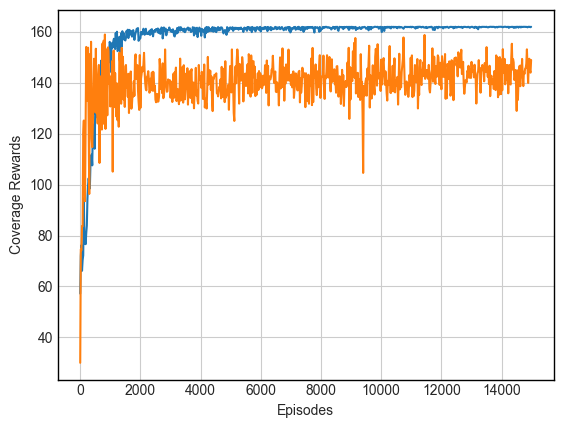

In [90]:
import pickle
import matplotlib.pyplot as plt

# 对数据进行采样，x轴按步长20显示
episodes_ebc = np.arange(len(ebc_test_returns)) * 20
episodes_bc = np.arange(len(bc_test_returns)) * 20

plt.plot(episodes_ebc[:750], ebc_test_returns[:750], label='SGE-EIL')
plt.plot(episodes_bc, bc_test_returns, label='SGE-IL')
plt.xlabel('Episodes')
plt.ylabel('Coverage Rewards')
plt.title('')
# plt.legend()  # 显示图例
plt.grid(True)
plt.show()

In [61]:
import pickle

# 保存数据到pickle文件
data_to_save = {
    'ebc_test_returns': ebc_test_returns,
    'bc_test_returns': bc_test_returns
}

# 保存为pickle文件
with open('one_room_training_results_0.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

print(f"数据已保存到 one_room_training_results_0.pkl")
print(f"EBC测试回报数量: {len(ebc_test_returns)}")
print(f"BC测试回报数量: {len(bc_test_returns)}")

数据已保存到 one_room_training_results_0.pkl
EBC测试回报数量: 750
BC测试回报数量: 750


In [ ]:
# # 加载数据
# with open('one_room_training_results_0.pkl', 'rb') as f:
#     loaded_data = pickle.load(f)
    
# ebc_test_returns = loaded_data['ebc_test_returns']
# bc_test_returns = loaded_data['bc_test_returns']

In [30]:
training_epochs=5

In [32]:
#test training time ebc lose and score
from ebcnet import EndToEndBehaviorCloning
while(training_epochs<10):
    ebc_test_returns = []
    state_dim_ebc=all_states.size(1)

    raw_sequences = []
    corresponding_actions = []

    print("正在从专家轨迹构建 (序列, 动作) 数据对...")
    for traj in elite_trajectories_data:
        states = [int(s.item()) for s in traj['states']]
        actions = traj['actions']
        
        # 轨迹中的每一步都是一个训练样本
        for t in range(len(actions)):
            # 构造当前时间步 t 的历史状态序列
            history_sequence = []
            current_history = states[:t+1]
            history_sequence[:len(current_history)] = current_history
            
            raw_sequences.append(history_sequence)
            corresponding_actions.append(actions[t])

    print(f"数据对构建完成，共 {len(raw_sequences)} 个样本。")
    sample_indices = np.random.randint(low=0, high=len(raw_sequences), size=64)

    # 注意：我们传递的是原始序列列表，而不是一个大的张量
    batch_sequences = [raw_sequences[i] for i in sample_indices]

    actions_tensor = torch.tensor(corresponding_actions, dtype=torch.long)
    batch_size = 64
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    ebc_agent = EndToEndBehaviorCloning(
        num_states=900, 
        embed_dim=16, 
        encoder_hidden_dim=32, 
        policy_hidden_dim=128, 
        action_dim=5, 
        lr=1e-3,
        device=device
    )


    with tqdm(total=n_iterations, desc="progress bar") as pbar:
        for i in range(n_iterations):
            sample_indices = np.random.randint(low=0, high=len(raw_sequences), size=batch_size)
            
            batch_sequences = [raw_sequences[i] for i in sample_indices]
            batch_actions = actions_tensor[sample_indices]
        
            loss=ebc_agent.learn(batch_sequences, batch_actions)
            if (i + 1) % 20 == 0:
                current_return = test_agent_EBC2(ebc_agent, env,100)
                ebc_test_returns.append(current_return)
                pbar.set_postfix({'return': '%.3f' % (current_return)})
            pbar.update(1)
    #test training time bc lose and score
    bc_test_returns = []
    bc_loss_returns = []

    state_dim_bc = H-1
    bc_agent = BehaviorClone(state_dim_bc, hidden_dim, action_dim, lr)
    with tqdm(total=n_iterations, desc="progress bar") as pbar:
        for i in range(n_iterations):
            sample_indices2 = np.random.randint(low=0,high=expert_s.shape[0],size=batch_size)
            loss=bc_agent.learn(expert_s[sample_indices2], expert_a[sample_indices2])
            bc_loss_returns.append(loss)
            if (i + 1) % 20 == 0:
                current_return = test_agent_BC(bc_agent, env, 100)
                bc_test_returns.append(current_return)
            pbar.update(1)

    # 保存数据到pickle文件
    data_to_save = {
        'ebc_test_returns': ebc_test_returns,
        'bc_test_returns': bc_test_returns
    }
    save_policy_model(ebc_agent.model, f'one_room_data/ebc_model_{training_epochs}.pt')
    # 保存为pickle文件
    with open(f'one_room_data/one_room_training_results_{training_epochs}.pkl', 'wb') as f:
        pickle.dump(data_to_save, f)

    print(f"数据已保存到 one_room_data/one_room_training_results_{training_epochs}.pkl")
    print(f"EBC测试回报数量: {len(ebc_test_returns)}")
    print(f"BC测试回报数量: {len(bc_test_returns)}")
    training_epochs+=1

正在从专家轨迹构建 (序列, 动作) 数据对...
数据对构建完成，共 1580 个样本。


progress bar: 100%|██████████| 15000/15000 [00:21<00:00, 700.15it/s]


Model saved to one_room_data/ebc_model_5.pt
数据已保存到 one_room_data/one_room_training_results_5.pkl
EBC测试回报数量: 750
BC测试回报数量: 750
正在从专家轨迹构建 (序列, 动作) 数据对...
数据对构建完成，共 1580 个样本。


progress bar: 100%|██████████| 15000/15000 [00:21<00:00, 706.05it/s]


Model saved to one_room_data/ebc_model_6.pt
数据已保存到 one_room_data/one_room_training_results_6.pkl
EBC测试回报数量: 750
BC测试回报数量: 750
正在从专家轨迹构建 (序列, 动作) 数据对...
数据对构建完成，共 1580 个样本。


progress bar: 100%|██████████| 15000/15000 [00:19<00:00, 761.37it/s]


Model saved to one_room_data/ebc_model_7.pt
数据已保存到 one_room_data/one_room_training_results_7.pkl
EBC测试回报数量: 750
BC测试回报数量: 750
正在从专家轨迹构建 (序列, 动作) 数据对...
数据对构建完成，共 1580 个样本。


progress bar: 100%|██████████| 15000/15000 [00:18<00:00, 803.54it/s]


Model saved to one_room_data/ebc_model_8.pt
数据已保存到 one_room_data/one_room_training_results_8.pkl
EBC测试回报数量: 750
BC测试回报数量: 750
正在从专家轨迹构建 (序列, 动作) 数据对...
数据对构建完成，共 1580 个样本。


progress bar: 100%|██████████| 15000/15000 [00:20<00:00, 742.77it/s]


Model saved to one_room_data/ebc_model_9.pt
数据已保存到 one_room_data/one_room_training_results_9.pkl
EBC测试回报数量: 750
BC测试回报数量: 750


已加载训练轮次 0 的数据
已加载训练轮次 1 的数据
已加载训练轮次 2 的数据
已加载训练轮次 3 的数据
已加载训练轮次 4 的数据
已加载训练轮次 5 的数据
已加载训练轮次 6 的数据
已加载训练轮次 7 的数据
已加载训练轮次 8 的数据
已加载训练轮次 9 的数据
基于 10 次运行的统计:
SGE-EIL 最终: 161.90±0.09
SGE-IL 最终:  143.17±5.93


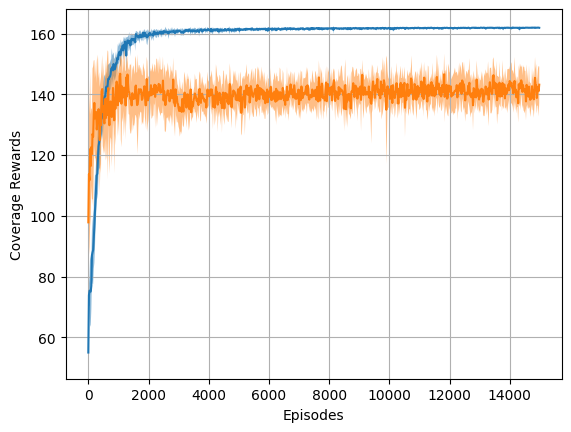

In [38]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os

# 加载多次运行的数据
all_ebc_returns = []
all_bc_returns = []

# 加载所有训练轮次的数据
for epoch in range(10):  # 假设有10次运行
    file_path = f'one_room_data/one_room_training_results_{epoch}.pkl'
    if os.path.exists(file_path):
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
            all_ebc_returns.append(data['ebc_test_returns'])
            all_bc_returns.append(data['bc_test_returns'])
        print(f"已加载训练轮次 {epoch} 的数据")

if all_ebc_returns:
    # 确保所有数据长度一致（取最短长度）
    min_length = min(len(returns) for returns in all_ebc_returns + all_bc_returns)
    
    # 截断到相同长度并转换为numpy数组
    ebc_array = np.array([returns[:min_length] for returns in all_ebc_returns])
    bc_array = np.array([returns[:min_length] for returns in all_bc_returns])
    
    # 计算均值和标准差
    ebc_mean = np.mean(ebc_array, axis=0)
    ebc_std = np.std(ebc_array, axis=0)
    bc_mean = np.mean(bc_array, axis=0)
    bc_std = np.std(bc_array, axis=0)
    
    # 对数据进行采样，x轴按步长20显示
    episodes_ebc = np.arange(len(ebc_mean)) * 20
    episodes_bc = np.arange(len(bc_mean)) * 20
    
    # 绘制均值线
    plt.plot(episodes_ebc, ebc_mean, label='SGE-EIL')
    plt.plot(episodes_bc, bc_mean, label='SGE-IL')
    
    # 添加标准差带
    plt.fill_between(episodes_ebc, ebc_mean - ebc_std, ebc_mean + ebc_std, 
                     alpha=0.5)
    plt.fill_between(episodes_bc, bc_mean - bc_std, bc_mean + bc_std, 
                     alpha=0.5)
    
    print(f"基于 {len(all_ebc_returns)} 次运行的统计:")
    print(f"SGE-EIL 最终: {ebc_mean[-1]:.2f}±{ebc_std[-1]:.2f}")
    print(f"SGE-IL 最终:  {bc_mean[-1]:.2f}±{bc_std[-1]:.2f}")
else:
    # 如果没有多次运行数据，就用原来的方式（单次运行）
    episodes_ebc = np.arange(len(ebc_test_returns)) * 20
    episodes_bc = np.arange(len(bc_test_returns)) * 20
    
    plt.plot(episodes_ebc, ebc_test_returns, label='SGE-EIL')
    plt.plot(episodes_bc, bc_test_returns, label='SGE-IL')
    print("使用单次运行数据绘图")

plt.xlabel('Episodes')
plt.ylabel('Coverage Rewards')
plt.title('')
# plt.legend()  # 显示图例
plt.grid(True)
plt.show()

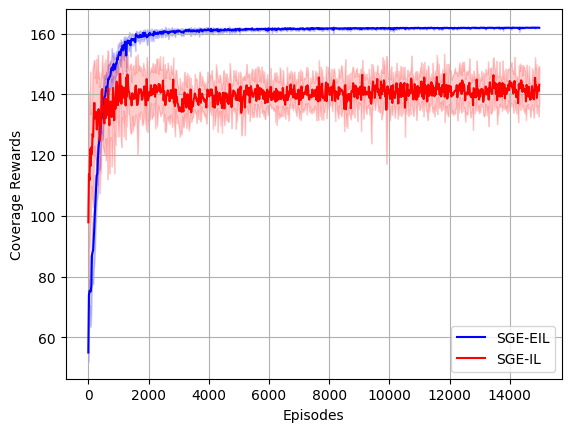

In [39]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os

# 加载多次运行的数据
all_ebc_returns = []
all_bc_returns = []

for epoch in range(10):  # 假设有10次运行
    file_path = f'one_room_data/one_room_training_results_{epoch}.pkl'
    if os.path.exists(file_path):
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
            all_ebc_returns.append(data['ebc_test_returns'])
            all_bc_returns.append(data['bc_test_returns'])

if all_ebc_returns:
    # 转换为numpy数组并计算统计量
    min_length = min(len(returns) for returns in all_ebc_returns + all_bc_returns)
    ebc_array = np.array([returns[:min_length] for returns in all_ebc_returns])
    bc_array = np.array([returns[:min_length] for returns in all_bc_returns])
    
    ebc_mean = np.mean(ebc_array, axis=0)
    ebc_std = np.std(ebc_array, axis=0)
    bc_mean = np.mean(bc_array, axis=0)
    bc_std = np.std(bc_array, axis=0)
    
    # 对数据进行采样，x轴按步长20显示
    episodes_ebc = np.arange(len(ebc_mean)) * 20
    episodes_bc = np.arange(len(bc_mean)) * 20
    
    # 绘制均值线和标准差带
    plt.plot(episodes_ebc, ebc_mean, label='SGE-EIL', color='blue')
    plt.plot(episodes_bc, bc_mean, label='SGE-IL', color='red')
    
    plt.fill_between(episodes_ebc, ebc_mean - ebc_std, ebc_mean + ebc_std, 
                     alpha=0.2, color='blue')
    plt.fill_between(episodes_bc, bc_mean - bc_std, bc_mean + bc_std, 
                     alpha=0.2, color='red')
else:
    # 如果没有多次运行数据，就用原来的方式
    episodes_ebc = np.arange(len(ebc_test_returns)) * 20
    episodes_bc = np.arange(len(bc_test_returns)) * 20
    
    plt.plot(episodes_ebc, ebc_test_returns, label='SGE-EIL')
    plt.plot(episodes_bc, bc_test_returns, label='SGE-IL')

plt.xlabel('Episodes')
plt.ylabel('Coverage Rewards')
plt.title('')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
min_return = []
max_return = []
mean_return = []
median_return = []
for iter in range(10):
    params["common"]["batch_size"]=1000
    ebc_agent = EndToEndBehaviorCloning(
        num_states=900, 
        embed_dim=16, 
        encoder_hidden_dim=32, 
        policy_hidden_dim=128, 
        action_dim=5, 
        lr=1e-3,
        device=device
    )
    ebc_agent.model.load_state_dict(torch.load(f'one_room_data/ebc_model_{0}.pt'))
    mat_state = []
    mat_return = []
    env.initialize()
    mat_state.append(env.state)
    init_state = env.state
    for h_iter in range(H-1):
        batch_state = append_state(mat_state, h_iter+1).long()
        logits = ebc_agent.model(batch_state)
        probs = torch.softmax(logits, dim=1)
        actions = torch.multinomial(probs, num_samples=1).squeeze(1)
        env.step(h_iter, actions)
        mat_state.append(env.state)  # s+1

    returns = env.weighted_traj_return(mat_state, type = params["alg"]["type"]).float()
    min_return.append(returns.min())
    max_return.append(returns.max())
    mean_return.append(returns.mean())
    median_return.append(returns.median())
mean_min_return = np.mean(min_return)
std_min_return = np.std(min_return)
mean_max_return = np.mean(max_return)
std_max_return = np.std(max_return)
mean_mean_return = np.mean(mean_return)
std_mean_return = np.std(mean_return)
mean_median_return = np.mean(median_return)
std_median_return = np.std(median_return)
print(f"min: {mean_min_return:.2f}±{std_min_return:.2f}, max: {mean_max_return:.2f}±{std_max_return:.2f}, mean: {mean_mean_return:.2f}±{std_mean_return:.2f}, median: {mean_median_return:.2f}±{std_median_return:.2f}")

min: 118.50±35.97, max: 162.00±0.00, mean: 161.85±0.08, median: 162.00±0.00


In [ ]:
# 修改热力图函数，将障碍物用棕色表示
import importlib
import visualization
importlib.reload(visualization)
from visualization import Visu
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.colors import ListedColormap

def visu_heatmap_with_obstacles(self, visit_frequency=None, path=None, title="Visit Frequency Heatmap"):
    """
    可视化热力图，显示访问频率或值分布，障碍物用棕色表示
    
    Args:
        visit_frequency: 字典或数组，包含每个格子的访问频率或值
        path: 可选的路径数据，格式为 [(t, s), ...]
        title: 图表标题
    """
    f, ax = plt.subplots(figsize=(self.x_shape, self.y_shape))
    
    # 创建热力图数据矩阵
    heatmap_data = np.zeros((self.y_shape, self.x_shape))
    obstacle_mask = np.zeros((self.y_shape, self.x_shape), dtype=bool)
    
    # 检测障碍物
    if hasattr(env, 'Hori_ActionTransitionMatrix') and env.Hori_ActionTransitionMatrix is not None:
        for cell in range(self.x_shape * self.y_shape):
            is_obstacle = True
            for action in range(env.action_dim):
                if env.Hori_ActionTransitionMatrix[cell, cell, action] != 1.0:
                    is_obstacle = False
                    break
            if is_obstacle:
                x_coord = cell % self.x_shape
                y_coord = int(cell / self.x_shape)
                obstacle_mask[y_coord, x_coord] = True
    
    # 填充访问频率数据
    if visit_frequency is not None:
        if isinstance(visit_frequency, dict):
            for key, value in visit_frequency.items():
                if isinstance(key, tuple):
                    s = key[1] if len(key) > 1 else key[0]
                else:
                    s = key
                x_coord = s % self.x_shape
                y_coord = int(s / self.x_shape)
                if 0 <= y_coord < self.y_shape and 0 <= x_coord < self.x_shape:
                    heatmap_data[y_coord, x_coord] += value
        elif isinstance(visit_frequency, (list, np.ndarray)):
            if len(visit_frequency) == self.x_shape * self.y_shape:
                heatmap_data = np.array(visit_frequency).reshape(self.y_shape, self.x_shape)
    
    # 创建自定义颜色映射
    # 对于障碍物，我们将使用棕色
    display_data = heatmap_data.copy()
    
    # 先绘制基础热力图
    im = ax.imshow(heatmap_data, cmap='viridis', aspect='equal', origin='lower', 
                   interpolation='nearest', alpha=0.8)
    
    # 在障碍物位置叠加棕色
    obstacle_data = np.ma.masked_where(~obstacle_mask, np.ones_like(heatmap_data))
    ax.imshow(obstacle_data, cmap='copper', aspect='equal', origin='lower', 
              interpolation='nearest', alpha=0.9, vmin=0, vmax=1)
    
    # 添加颜色条
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Visit Frequency', rotation=270, labelpad=15)
    
    # 设置网格
    ax.set_xticks(np.arange(-0.5, self.x_shape, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, self.y_shape, 1), minor=True)
    ax.grid(which='minor', color='white', linestyle='-', linewidth=1.0, alpha=0.7)
    
    # 设置主要刻度
    ax.set_xticks(np.arange(0, self.x_shape, 1))
    ax.set_yticks(np.arange(0, self.y_shape, 1))
    ax.grid(which='major', visible=False)  # 不显示主网格线
    
    # 在每个格子中显示数值或障碍物标记
    for i in range(self.y_shape):
        for j in range(self.x_shape):
            if obstacle_mask[i, j]:
                # 障碍物显示 
                ax.text(j, i, '', ha="center", va="center", 
                       color="white", fontweight='bold', fontsize=12)
            elif heatmap_data[i, j] > 0:
                # 访问频率数值
                text_color = "white" if heatmap_data[i, j] < heatmap_data.max()/2 else "black"
                ax.text(j, i, f'{int(heatmap_data[i, j])}',
                       ha="center", va="center", 
                       color=text_color, fontweight='bold')
    
    # 如果有路径，绘制路径
    if path is not None:
        x_path = []
        y_path = []
        for cell in path:
            if isinstance(cell, tuple):
                cell_pos = cell[1] if len(cell) > 1 else cell[0]
            else:
                cell_pos = cell
            x_path.append(cell_pos % self.x_shape)
            y_path.append(int(cell_pos / self.x_shape))
        
        # 绘制路径线
        if len(x_path) > 1:
            ax.plot(x_path, y_path, 'r-', linewidth=3, alpha=0.8, label='Path')
        
        # 标记起点和终点
        if len(x_path) > 0:
            ax.plot(x_path[0], y_path[0], '*', color='orange', markersize=15, 
                   markeredgecolor='black', markeredgewidth=1, label='Start')
            if len(x_path) > 1:
                ax.plot(x_path[-1], y_path[-1], '*', color='lime', markersize=15,
                       markeredgecolor='black', markeredgewidth=1, label='End')
            ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    
    # 设置标题和标签
    ax.set_title(f"{title}\nAverage Return {self.ret:.2f}")
    ax.set_xlim(-0.5, self.x_shape-0.5)
    ax.set_ylim(-0.5, self.y_shape-0.5)
    
    # 设置坐标轴标签
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    
    plt.tight_layout()
    self.iter += 1
    return plt, f

def visu_state_visits_with_obstacles(self, states_list, path=None):
    """
    根据状态列表创建访问频率热力图，包含障碍物显示
    
    Args:
        states_list: 状态列表，可以是 [s1, s2, s3, ...] 或 [tensor1, tensor2, ...]
        path: 可选的路径数据
    """
    # 统计每个状态的访问次数
    visit_counts = {}
    
    for state in states_list:
        if isinstance(state, torch.Tensor):
            state_val = state.item()
        else:
            state_val = state
            
        if state_val in visit_counts:
            visit_counts[state_val] += 1
        else:
            visit_counts[state_val] = 1
    
    return self.visu_heatmap_with_obstacles(visit_counts, path, "State Visit Frequency")

# 动态添加新方法到 Visu 类
Visu.visu_heatmap_with_obstacles = visu_heatmap_with_obstacles
Visu.visu_state_visits_with_obstacles = visu_state_visits_with_obstacles

print("带障碍物显示的热力图功能已成功添加到 Visu 类！")

带障碍物显示的热力图功能已成功添加到 Visu 类！


In [135]:
def test_agent_EBC_2(agent, env, n_episode,appear=False):
    env.common_params["batch_size"] = n_episode
    mat_state = []
    mat_return = []
    env.initialize()
    mat_state.append(env.state)
    init_state = env.state
    for h_iter in range(H-1):
        batch_state = append_state(mat_state, h_iter+1).long()
        logits = agent.model(batch_state)
        probs = torch.softmax(logits, dim=1)
        actions = torch.multinomial(probs, num_samples=1).squeeze(1)
        env.step(h_iter, actions)
        mat_state.append(env.state)  # s+1

    mat_return = env.weighted_traj_return(mat_state, type = params["alg"]["type"]).float().mean()
    if appear==True:
        obj = env.weighted_traj_return(mat_state).float()
        print( " mean ", obj.mean(), " max ",
                  obj.max(), " median ", obj.median(), " min ", obj.min())
    return mat_return, mat_state

In [1]:
# 测试带障碍物的热力图功能

# 创建可视化对象
visu = Visu(env_params=params["env"])

mat_return, mat_states = test_agent_EBC_2(ebc_agent, env,100)
all_states = []
# 将所有状态从 mat_states 中提取出来
for traj in mat_states:
    all_states.extend(traj)

# 设置返回值
visu.path_return(mat_return)

print(f"使用了前20条轨迹，总访问状态数: {len(all_states)}")

# 创建带障碍物的访问频率热力图
plt_heatmap, fig_heatmap = visu.visu_state_visits_with_obstacles(all_states)
plt_heatmap.show()

NameError: name 'Visu' is not defined